# CS156 Final Project
# Pokemon Classifier and Generator
### Yuhao Chen
### Fall 2019

## Letter to Prof. Sterne
Dear Prof. Sterne,

Thank you so much for your help on my project. Without your help, I will not be able to finish this project. I should have submited a jupyter notebook with all cells rerun. However, the re-training takes a long time, and I fail to finish the re-training before the due of this assignment. Therefore, I just submit this version. 

All the codes in this notebook are arranged in the correct sequence, which means if you run the code cells one by one, it will return the correct result.

Please contact me if there is any question concerning my code or there is anything unclear or missing. 

Thanks again! Have a good vacation.


Best regard,

Yuhao

## Library Importing

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from PIL import Image
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D , Flatten, Activation, BatchNormalization, Dropout, LeakyReLU, Input
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import tensorflow as tf 
from keras.applications.vgg16 import VGG16,preprocess_input
import heapq
from keras import backend 

/Users/cyhsmac/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/cyhsmac/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/cyhsmac/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will 

## Data Loading and Processing

In [2]:
dirnames=glob('dataset/*')

imgs_set=[]
labels_set=[]

# Normalization function to normalize pixel's RGB values
def normalize_img(img):
    return np.array((img-np.min(img))/(np.max(img)-np.min(img)))

# Open files
for dirname in dirnames:
    label=dirname[8:]
    imgs=glob(dirname+'/*')
    for img in imgs:
        if img[-3:]=='jpg':
            im=Image.open(img)
            im=im.convert('RGB')
            # Resize the image
            im=np.array(im.resize((128,128)))
            # Normalize the pixels
            im=normalize_img(im)
            imgs_set.append(im)
            labels_set.append(label)

In [3]:
# Store the images in array
imgs_set=np.array(imgs_set)

In [4]:
# Print the Shape of the image set
imgs_set.shape

(10118, 128, 128, 3)

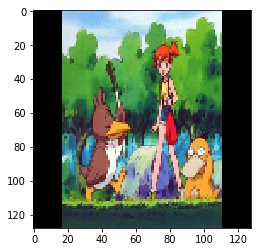

In [92]:
# Randomly print a picture to show the data sample
plt.imshow(imgs_set[-1])
plt.show()

In [93]:
# Factorize the labels into a label array and a label map
labels=pd.factorize(labels_set)
processed_labels=to_categorical(labels[0],149)

In [96]:
# Shuffle the data set and label set so that they are more random
img_data, img_label=shuffle(imgs_set,processed_labels, random_state=23)

# Split the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(img_data,img_label,test_size=0.2,random_state=23)

## Model Building and Data Training

### New designed CNN

In [181]:
model=Sequential()
# First conv layer with input size definition
model.add(Conv2D(32,(3,3),padding='same',input_shape=(128,128,3)))
# Activation function with relu
model.add(Activation("relu"))
# Batch normalization for faster training and better optimizing
model.add(BatchNormalization(axis=-1))
# Use maxpooling to decrease the dimension and data size 
model.add(MaxPooling2D(pool_size=(3,3)))
# Add dropout to avoid overfitting
model.add(Dropout(0.25))

# Repeat with larger filter dimension 64
model.add(Conv2D(64,(3,3),padding='same'))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(64,(3,3),padding='same'))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Repeat with larger filter dimension 128
model.add(Conv2D(128,(3,3),padding='same'))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(128,(3,3),padding='same'))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Add fully connect layer
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))          

# Final fully connected layer for classification result
model.add(Dense(149))
# Use Softmax as activation function
model.add(Activation(tf.nn.softmax))

# Use Adam as the optimizer and categorical crossentrophy as loss function calculating method
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_141 (Conv2D)          (None, 128, 128, 32)      896       
_________________________________________________________________
activation_41 (Activation)   (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 42, 42, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 42, 42, 32)        0         
_________________________________________________________________
conv2d_142 (Conv2D)          (None, 42, 42, 64)        18496     
_________________________________________________________________
activation_42 (Activation)   (None, 42, 42, 64)        0         
__________

In [175]:
# Fit the model with data, train the model
md=model.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1, validation_data=(X_test, y_test))

Train on 3576 samples, validate on 894 samples
Epoch 1/20
3576/3576 [==============================] - 203s 57ms/step - loss: 6.0585 - acc: 0.0126 - val_loss: 5.1060 - val_acc: 0.0313
Epoch 2/20
3576/3576 [==============================] - 184s 51ms/step - loss: 5.0547 - acc: 0.0526 - val_loss: 4.8256 - val_acc: 0.0515
Epoch 3/20
3576/3576 [==============================] - 184s 51ms/step - loss: 4.4790 - acc: 0.0959 - val_loss: 4.6099 - val_acc: 0.0828
Epoch 4/20
3576/3576 [==============================] - 182s 51ms/step - loss: 3.9697 - acc: 0.1546 - val_loss: 4.3206 - val_acc: 0.1085
Epoch 5/20
3576/3576 [==============================] - 182s 51ms/step - loss: 3.5015 - acc: 0.2164 - val_loss: 4.2454 - val_acc: 0.1309
Epoch 6/20
3576/3576 [==============================] - 182s 51ms/step - loss: 3.1211 - acc: 0.2813 - val_loss: 4.0912 - val_acc: 0.1678
Epoch 7/20
3576/3576 [==============================] - 182s 51ms/step - loss: 2.7094 - acc: 0.3610 - val_loss: 4.0017 - val_acc: 0

In [160]:
# Define a function to plot the accuracy change and loss change during the training process
def plot_training_result(md):
    loss=md.history['loss']
    val_loss=md.history['val_loss']
    
    # Plot for accuracy change in both train and test set
    train_accuracy=md.history['acc']
    val_accuracy=md.history['val_acc']
    plt.plot(loss,label='train_loss')
    plt.plot(val_loss,label='validation_loss')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train vs Validation Loss')
    plt.show()

    # Plot for loss change in both train and test set
    plt.plot(train_accuracy,label='train_accuracy')
    plt.plot(val_accuracy,label='validation_accuracy')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Train vs Validation Accuracy')
    plt.show()

In [ ]:
# Plot the result
plot_training_result(md)

### CNN with VGG16 Preprocessing

In [158]:
model2=Sequential()

# Add VGG16 network and load imagenet weights
conv_base=VGG16(weights='imagenet',include_top=False,input_shape=(128,128,3))
conv_base.trainable = False
model2.add(conv_base)

# Add a fully connected layer as the classifier
model2.add(Flatten())
model2.add(Dense(1024))
model2.add(Activation("relu"))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))          

# Return 149 categories classifcation result
model2.add(Dense(149))
model2.add(Activation(tf.nn.softmax))

# Use Adam as optimizer. Set learning rate as 0.0002. Set loss function categorical cross entrophy
model2.compile(Adam(lr=0.0002), loss='categorical_crossentropy', metrics=["accuracy"])

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 1024)              8389632   
_________________________________________________________________
activation_3 (Activation)    (None, 1024)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 149)               152725    
__________

In [159]:
# Add early stopping to stop overfitting and too long time of traing
early_stopping = EarlyStopping(monitor='val_acc', patience=3, verbose=1, min_delta=0.01)

# Fit the model
md2=model2.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stopping])

Train on 8094 samples, validate on 2024 samples
Epoch 1/20
8094/8094 [==============================] - 1367s 169ms/step - loss: 4.4079 - acc: 0.1565 - val_loss: 3.3788 - val_acc: 0.3039
Epoch 2/20
8094/8094 [==============================] - 1345s 166ms/step - loss: 2.4394 - acc: 0.4685 - val_loss: 2.7251 - val_acc: 0.4170
Epoch 3/20
8094/8094 [==============================] - 1338s 165ms/step - loss: 1.6125 - acc: 0.6470 - val_loss: 2.6459 - val_acc: 0.4269
Epoch 4/20
8094/8094 [==============================] - 1341s 166ms/step - loss: 1.1152 - acc: 0.7598 - val_loss: 2.5334 - val_acc: 0.4560
Epoch 5/20
8094/8094 [==============================] - 1338s 165ms/step - loss: 0.8148 - acc: 0.8385 - val_loss: 2.4983 - val_acc: 0.4679
Epoch 6/20
8094/8094 [==============================] - 1338s 165ms/step - loss: 0.6187 - acc: 0.8857 - val_loss: 2.5234 - val_acc: 0.4659
Epoch 7/20
8094/8094 [==============================] - 1336s 165ms/step - loss: 0.4772 - acc: 0.9151 - val_loss: 2.50

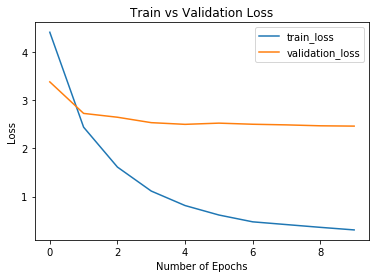

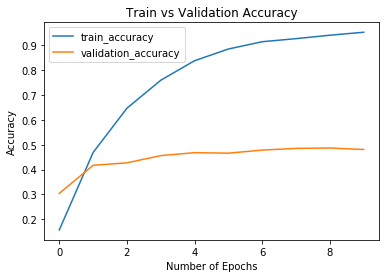

In [162]:
# Print the graph of accuracy and loss change
plot_training_result(md2)

## Result Presentation(with VGG16 Preprocessing model)

In [238]:
# Define a function to predict the pokemon with the trained model
def predict_pokemon(file_name,model):
    
    # Open a file of Pokemon image
    pi_list=[]
    pi=Image.open(file_name)
    
    # Show the Pokemon Image
    plt.imshow(pi)
    plt.title('Input picture')
    plt.show()
    
    # Image processing
    pi=pi.convert('RGB')
    pi=np.array(pi.resize((128,128)))
    pi=normalize_img(pi)
    pi_list.append(pi)
    pi_list=np.array(pi_list)
    
    # Predict the pokemon name with the trained model
    pi_predict=model.predict_classes(pi_list)
    pokemon_predict=labels[1][pi_predict[0]]
    
    # Print the result
    print("Prediction: \nThe pokemon is --",pokemon_predict)
    
    # Print a sample picture of the pokemon
    imgname=glob('dataset/'+pokemon_predict+'/*')[5]
    img=Image.open(imgname)
    plt.imshow(img)
    plt.title('Sample image of the pokemon')
    plt.show()

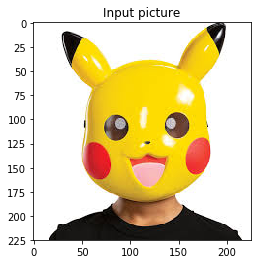

Prediction: 
The pokemon is -- Pikachu


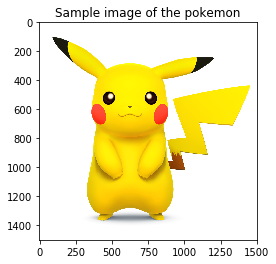

In [295]:
# Load a random picture downloaded from Google Images and predict the name
predict_pokemon('pika.jpeg',model2)

In [241]:
# Define a function to predict the top five possibility of the pokemon
def predict_top_5_prob(file_name,model):
    pi_list=[]
    pi=Image.open(file_name)
    
    pi=pi.convert('RGB')
    pi=np.array(pi.resize((128,128)))
    pi=normalize_img(pi)
    pi_list.append(pi)
    pi_list=np.array(pi_list)
    
    # Print the result with the top 5 probabilities
    pi_predict=model.predict_proba(pi_list)
    pi_predict=pi_predict[0].tolist()
    max_5_index = map(pi_predict.index, heapq.nlargest(5, pi_predict))
    
    i=0
    for ind in max_5_index:
        i+=1
        pokemon_predict=labels[1][ind]
        print("\nThe rank %i probability of the pokemon is %s" % (i,pokemon_predict))

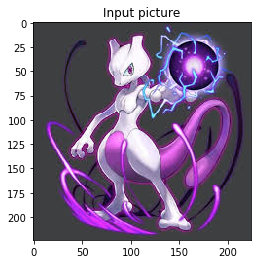

Prediction: 
The pokemon is -- Mewtwo


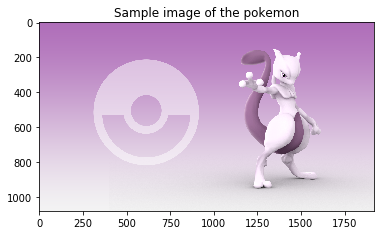


The rank 1 probability of the pokemon is Mewtwo

The rank 2 probability of the pokemon is Cloyster

The rank 3 probability of the pokemon is Bulbasaur

The rank 4 probability of the pokemon is Nidoqueen

The rank 5 probability of the pokemon is Gastly


In [296]:
# Predict another pokemon image and print the top 5 probabilities
predict_pokemon('mm.jpeg',model2)
predict_top_5_prob('mm.jpeg',model2)

### Plot prediction distribution

In [248]:
# Predict the test set and store all results
X_test_predict_result=model2.predict(X_test)

In [277]:
# Define a function to understand: if we want to select to first X probabilities so that the correct answer is in
# these probabilities, what will be the value of x
def check_result_dis(result):
    index_correct=[]
    for i in range(len(result)):
        correct_result=y_test[i].tolist().index(1)
        result_list=result[i].tolist()
        prob_list=sorted(result[i])[::-1]
        for p in range(len(prob_list)):
            if result_list.index(prob_list[p])==correct_result:
                index_correct.append(p+1)
                break
    return index_correct
                

index_correct=check_result_dis(X_test_predict_result)

In [278]:
# Define a function to return the accuracy of the model if we consider the right label prediction in the top x predictions as correct
def check_top_x(l, x):
    total_num=0
    inlist_num=0
    for i in l:
        if i<=x:
            inlist_num+=1
        total_num+=1
    return inlist_num/total_num

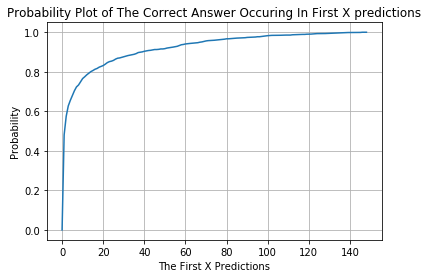

In [287]:
# Plot the Probability Plot of The Correct Answer Occuring In First X predictions
prob_list=[]
for i in range(149):
    prob_list.append(check_top_x(index_correct, i))
    
plt.plot(prob_list)
plt.grid(True)
plt.title("Probability Plot of The Correct Answer Occuring In First X predictions")
plt.xlabel("The First X Predictions")
plt.ylabel("Probability")
plt.show()

## Pokemon Generator with GAN

### Set parameters

In [297]:
noise_dim = 100
batch_size = 32
steps_per_epoch = 4
epochs = 1500
img_rows, img_cols, channels = 50, 50, 1
optimizer = Adam(0.0002, 0.5)

In [298]:
# Import new data for this training
imgs=glob('gan_data/*')

imgs_set2=[]

# Change the image to black and white for easier training task
def rgb_gray(rgb):
    r,g,b=rgb[0], rgb[1], rgb[2]
    gray=0.2989*r+0.5870*g+0.1140*b
    return gray

for img in imgs:
    im=Image.open(img)
    im=im.convert('RGBA')
    im=np.array(im.resize((img_rows,img_cols)))
    new_im=[]
    for row in im:
        new_row=[]
        for col in row:
            new_row.append(rgb_gray(col[:3].tolist()))
        new_im.append(new_row)
    imgs_set2.append(new_im)

imgs_set2=np.array(imgs_set2)

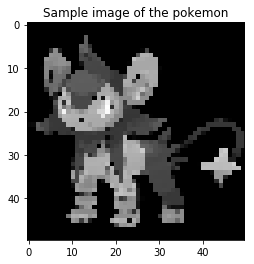

In [299]:
# Show a sample image
plt.imshow(imgs_set2[1],cmap="gray")
plt.title('Sample image of the pokemon')
plt.show()

In [300]:
imgs_set2 = (imgs_set2.astype(np.float32) - 127.5) / 127.5
imgs_set2 = imgs_set2.reshape(-1, img_rows*img_cols*channels)
imgs_set2.shape

(100, 2500)

In [301]:
# Generator of GAN
def create_generator():
    generator = Sequential()
    
    generator.add(Dense(256, input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(img_rows*img_cols*channels, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

In [302]:
# Discriminator of GAN
def create_discriminator():
    discriminator = Sequential()
     
    discriminator.add(Dense(1024, input_dim=img_rows*img_cols*channels))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [303]:
# Set the model with discriminator and generator
discriminator = create_discriminator()
generator = create_generator()

# Use discriminator to judge
discriminator.trainable = False

# Input noise and generate image based on it
gan_input = Input(shape=(noise_dim,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

In [304]:
# Run 1500 epochs to train the generator and compare the generated images with existing image by using discriminator
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_x = generator.predict(noise)

        real_x = imgs_set2[np.random.randint(0, imgs_set2.shape[0], size=batch_size)]
        
        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        d_loss = discriminator.train_on_batch(x, disc_y)

        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f'Epoch: {epoch} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')

/Users/cyhsmac/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 0 	 Discriminator Loss: 0.6482628583908081 		 Generator Loss: 0.7231426239013672
Epoch: 1 	 Discriminator Loss: 0.5868361592292786 		 Generator Loss: 0.8541193604469299
Epoch: 2 	 Discriminator Loss: 0.4687926471233368 		 Generator Loss: 1.1275889873504639
Epoch: 3 	 Discriminator Loss: 0.4857107400894165 		 Generator Loss: 1.1264674663543701
Epoch: 4 	 Discriminator Loss: 0.6295309066772461 		 Generator Loss: 0.8814029097557068
Epoch: 5 	 Discriminator Loss: 0.5612835884094238 		 Generator Loss: 0.8722777366638184
Epoch: 6 	 Discriminator Loss: 0.554194450378418 		 Generator Loss: 0.8362867832183838
Epoch: 7 	 Discriminator Loss: 0.49957260489463806 		 Generator Loss: 0.9481030702590942
Epoch: 8 	 Discriminator Loss: 0.5258437395095825 		 Generator Loss: 0.9105178117752075
Epoch: 9 	 Discriminator Loss: 0.5517118573188782 		 Generator Loss: 1.028209924697876
Epoch: 10 	 Discriminator Loss: 0.5798919200897217 		 Generator Loss: 0.9673261046409607
Epoch: 11 	 Discriminator Loss: 

Epoch: 93 	 Discriminator Loss: 0.7650940418243408 		 Generator Loss: 0.31689542531967163
Epoch: 94 	 Discriminator Loss: 0.45295268297195435 		 Generator Loss: 1.5140827894210815
Epoch: 95 	 Discriminator Loss: 0.3685380816459656 		 Generator Loss: 1.7961030006408691
Epoch: 96 	 Discriminator Loss: 0.42810338735580444 		 Generator Loss: 1.5479234457015991
Epoch: 97 	 Discriminator Loss: 0.44685161113739014 		 Generator Loss: 1.8353636264801025
Epoch: 98 	 Discriminator Loss: 0.42708563804626465 		 Generator Loss: 2.2524518966674805
Epoch: 99 	 Discriminator Loss: 0.5164865255355835 		 Generator Loss: 1.026329517364502
Epoch: 100 	 Discriminator Loss: 0.3575620651245117 		 Generator Loss: 1.8689939975738525
Epoch: 101 	 Discriminator Loss: 0.539673388004303 		 Generator Loss: 2.4339308738708496
Epoch: 102 	 Discriminator Loss: 0.41960328817367554 		 Generator Loss: 1.3176941871643066
Epoch: 103 	 Discriminator Loss: 0.40334200859069824 		 Generator Loss: 1.520042061805725
Epoch: 104 	 

Epoch: 185 	 Discriminator Loss: 0.23503050208091736 		 Generator Loss: 3.2059972286224365
Epoch: 186 	 Discriminator Loss: 0.24425312876701355 		 Generator Loss: 2.9302902221679688
Epoch: 187 	 Discriminator Loss: 0.24864579737186432 		 Generator Loss: 2.599411964416504
Epoch: 188 	 Discriminator Loss: 0.2583114504814148 		 Generator Loss: 3.111420154571533
Epoch: 189 	 Discriminator Loss: 0.22981339693069458 		 Generator Loss: 3.659977674484253
Epoch: 190 	 Discriminator Loss: 0.2597167491912842 		 Generator Loss: 2.739408254623413
Epoch: 191 	 Discriminator Loss: 0.2907373905181885 		 Generator Loss: 4.159879684448242
Epoch: 192 	 Discriminator Loss: 0.23042196035385132 		 Generator Loss: 3.8134055137634277
Epoch: 193 	 Discriminator Loss: 0.2348206341266632 		 Generator Loss: 3.948084592819214
Epoch: 194 	 Discriminator Loss: 0.38631540536880493 		 Generator Loss: 4.514334201812744
Epoch: 195 	 Discriminator Loss: 0.2674732804298401 		 Generator Loss: 3.0856435298919678
Epoch: 196 

Epoch: 276 	 Discriminator Loss: 0.21828700602054596 		 Generator Loss: 4.868379592895508
Epoch: 277 	 Discriminator Loss: 0.24979200959205627 		 Generator Loss: 3.8945930004119873
Epoch: 278 	 Discriminator Loss: 0.3036852777004242 		 Generator Loss: 2.239548683166504
Epoch: 279 	 Discriminator Loss: 0.21920831501483917 		 Generator Loss: 5.9490532875061035
Epoch: 280 	 Discriminator Loss: 0.20801904797554016 		 Generator Loss: 4.081603527069092
Epoch: 281 	 Discriminator Loss: 0.24852585792541504 		 Generator Loss: 4.568089485168457
Epoch: 282 	 Discriminator Loss: 0.2692040205001831 		 Generator Loss: 3.750354290008545
Epoch: 283 	 Discriminator Loss: 0.2364480197429657 		 Generator Loss: 3.801302671432495
Epoch: 284 	 Discriminator Loss: 0.22189924120903015 		 Generator Loss: 4.629324913024902
Epoch: 285 	 Discriminator Loss: 0.20390194654464722 		 Generator Loss: 4.573669910430908
Epoch: 286 	 Discriminator Loss: 0.19588075578212738 		 Generator Loss: 3.912463426589966
Epoch: 287 

Epoch: 368 	 Discriminator Loss: 0.2323560118675232 		 Generator Loss: 3.5312366485595703
Epoch: 369 	 Discriminator Loss: 0.21285000443458557 		 Generator Loss: 4.273262023925781
Epoch: 370 	 Discriminator Loss: 0.27536535263061523 		 Generator Loss: 3.6765336990356445
Epoch: 371 	 Discriminator Loss: 0.22413277626037598 		 Generator Loss: 3.957235336303711
Epoch: 372 	 Discriminator Loss: 0.24569851160049438 		 Generator Loss: 4.205249786376953
Epoch: 373 	 Discriminator Loss: 0.2196071743965149 		 Generator Loss: 4.099228382110596
Epoch: 374 	 Discriminator Loss: 0.2141430526971817 		 Generator Loss: 3.6166927814483643
Epoch: 375 	 Discriminator Loss: 0.22474360466003418 		 Generator Loss: 4.525041580200195
Epoch: 376 	 Discriminator Loss: 0.25953564047813416 		 Generator Loss: 3.221999168395996
Epoch: 377 	 Discriminator Loss: 0.22759801149368286 		 Generator Loss: 3.4823293685913086
Epoch: 378 	 Discriminator Loss: 0.23079094290733337 		 Generator Loss: 3.267587661743164
Epoch: 37

Epoch: 460 	 Discriminator Loss: 0.27872782945632935 		 Generator Loss: 3.428800344467163
Epoch: 461 	 Discriminator Loss: 0.2328997552394867 		 Generator Loss: 4.159412384033203
Epoch: 462 	 Discriminator Loss: 0.21858790516853333 		 Generator Loss: 3.9885706901550293
Epoch: 463 	 Discriminator Loss: 0.2884858250617981 		 Generator Loss: 2.5965218544006348
Epoch: 464 	 Discriminator Loss: 0.33502161502838135 		 Generator Loss: 2.7250747680664062
Epoch: 465 	 Discriminator Loss: 0.18053245544433594 		 Generator Loss: 4.831303119659424
Epoch: 466 	 Discriminator Loss: 0.23787599802017212 		 Generator Loss: 4.0765485763549805
Epoch: 467 	 Discriminator Loss: 0.27326568961143494 		 Generator Loss: 4.201178550720215
Epoch: 468 	 Discriminator Loss: 0.22749970853328705 		 Generator Loss: 4.621892929077148
Epoch: 469 	 Discriminator Loss: 0.2294500321149826 		 Generator Loss: 4.541750907897949
Epoch: 470 	 Discriminator Loss: 0.20605674386024475 		 Generator Loss: 4.283590793609619
Epoch: 47

Epoch: 552 	 Discriminator Loss: 0.21557331085205078 		 Generator Loss: 4.176122665405273
Epoch: 553 	 Discriminator Loss: 0.259463369846344 		 Generator Loss: 3.0965282917022705
Epoch: 554 	 Discriminator Loss: 0.3546500504016876 		 Generator Loss: 2.5608785152435303
Epoch: 555 	 Discriminator Loss: 0.22272947430610657 		 Generator Loss: 4.060549736022949
Epoch: 556 	 Discriminator Loss: 0.43525898456573486 		 Generator Loss: 1.7752175331115723
Epoch: 557 	 Discriminator Loss: 0.18089833855628967 		 Generator Loss: 5.68349027633667
Epoch: 558 	 Discriminator Loss: 0.2525174617767334 		 Generator Loss: 3.9406797885894775
Epoch: 559 	 Discriminator Loss: 0.21394890546798706 		 Generator Loss: 3.8858437538146973
Epoch: 560 	 Discriminator Loss: 0.1924545168876648 		 Generator Loss: 4.559817314147949
Epoch: 561 	 Discriminator Loss: 0.2288770079612732 		 Generator Loss: 4.06007719039917
Epoch: 562 	 Discriminator Loss: 0.2774543762207031 		 Generator Loss: 3.175225257873535
Epoch: 563 	 D

Epoch: 644 	 Discriminator Loss: 0.23903241753578186 		 Generator Loss: 4.017560005187988
Epoch: 645 	 Discriminator Loss: 0.23483413457870483 		 Generator Loss: 3.7403082847595215
Epoch: 646 	 Discriminator Loss: 0.2637453079223633 		 Generator Loss: 3.349860191345215
Epoch: 647 	 Discriminator Loss: 0.17556151747703552 		 Generator Loss: 4.70609188079834
Epoch: 648 	 Discriminator Loss: 0.2645453214645386 		 Generator Loss: 3.424983263015747
Epoch: 649 	 Discriminator Loss: 0.2115737795829773 		 Generator Loss: 3.908406972885132
Epoch: 650 	 Discriminator Loss: 0.23604705929756165 		 Generator Loss: 3.7576823234558105
Epoch: 651 	 Discriminator Loss: 0.3783930242061615 		 Generator Loss: 2.2883293628692627
Epoch: 652 	 Discriminator Loss: 0.22246906161308289 		 Generator Loss: 3.903689384460449
Epoch: 653 	 Discriminator Loss: 0.19629940390586853 		 Generator Loss: 4.088629245758057
Epoch: 654 	 Discriminator Loss: 0.18402712047100067 		 Generator Loss: 4.573734283447266
Epoch: 655 	

Epoch: 736 	 Discriminator Loss: 0.2965078353881836 		 Generator Loss: 3.3860411643981934
Epoch: 737 	 Discriminator Loss: 0.23190830647945404 		 Generator Loss: 3.5403270721435547
Epoch: 738 	 Discriminator Loss: 0.4436523914337158 		 Generator Loss: 2.8211007118225098
Epoch: 739 	 Discriminator Loss: 0.2843652367591858 		 Generator Loss: 2.9612245559692383
Epoch: 740 	 Discriminator Loss: 0.18469807505607605 		 Generator Loss: 5.0733137130737305
Epoch: 741 	 Discriminator Loss: 0.1765766441822052 		 Generator Loss: 4.9373884201049805
Epoch: 742 	 Discriminator Loss: 0.30306845903396606 		 Generator Loss: 3.2379517555236816
Epoch: 743 	 Discriminator Loss: 0.27300360798835754 		 Generator Loss: 3.3252410888671875
Epoch: 744 	 Discriminator Loss: 0.2520720660686493 		 Generator Loss: 3.073564052581787
Epoch: 745 	 Discriminator Loss: 0.25277286767959595 		 Generator Loss: 3.4931957721710205
Epoch: 746 	 Discriminator Loss: 0.28508713841438293 		 Generator Loss: 3.6279468536376953
Epoch

Epoch: 828 	 Discriminator Loss: 0.23919126391410828 		 Generator Loss: 3.7923407554626465
Epoch: 829 	 Discriminator Loss: 0.24344202876091003 		 Generator Loss: 3.9084558486938477
Epoch: 830 	 Discriminator Loss: 0.2462858110666275 		 Generator Loss: 4.102395534515381
Epoch: 831 	 Discriminator Loss: 0.25656723976135254 		 Generator Loss: 3.252023696899414
Epoch: 832 	 Discriminator Loss: 0.27954718470573425 		 Generator Loss: 3.4061930179595947
Epoch: 833 	 Discriminator Loss: 0.18056833744049072 		 Generator Loss: 4.37343692779541
Epoch: 834 	 Discriminator Loss: 0.3109305799007416 		 Generator Loss: 3.4607105255126953
Epoch: 835 	 Discriminator Loss: 0.28049302101135254 		 Generator Loss: 2.6591641902923584
Epoch: 836 	 Discriminator Loss: 0.2806987762451172 		 Generator Loss: 3.0844340324401855
Epoch: 837 	 Discriminator Loss: 0.24729371070861816 		 Generator Loss: 3.803755283355713
Epoch: 838 	 Discriminator Loss: 0.24611327052116394 		 Generator Loss: 3.2020626068115234
Epoch: 

Epoch: 920 	 Discriminator Loss: 0.29950833320617676 		 Generator Loss: 2.6384260654449463
Epoch: 921 	 Discriminator Loss: 0.2847641706466675 		 Generator Loss: 3.8420963287353516
Epoch: 922 	 Discriminator Loss: 0.22008582949638367 		 Generator Loss: 3.573322057723999
Epoch: 923 	 Discriminator Loss: 0.29481005668640137 		 Generator Loss: 3.0471816062927246
Epoch: 924 	 Discriminator Loss: 0.24785050749778748 		 Generator Loss: 3.4369606971740723
Epoch: 925 	 Discriminator Loss: 0.24075458943843842 		 Generator Loss: 3.965491533279419
Epoch: 926 	 Discriminator Loss: 0.28950661420822144 		 Generator Loss: 2.6668176651000977
Epoch: 927 	 Discriminator Loss: 0.23373572528362274 		 Generator Loss: 3.6032097339630127
Epoch: 928 	 Discriminator Loss: 0.27387088537216187 		 Generator Loss: 3.2394003868103027
Epoch: 929 	 Discriminator Loss: 0.21810510754585266 		 Generator Loss: 3.686715602874756
Epoch: 930 	 Discriminator Loss: 0.32779139280319214 		 Generator Loss: 3.203988552093506
Epoc

Epoch: 1011 	 Discriminator Loss: 0.2534729242324829 		 Generator Loss: 3.156130790710449
Epoch: 1012 	 Discriminator Loss: 0.21273460984230042 		 Generator Loss: 3.4831695556640625
Epoch: 1013 	 Discriminator Loss: 0.26457005739212036 		 Generator Loss: 2.8537182807922363
Epoch: 1014 	 Discriminator Loss: 0.20330017805099487 		 Generator Loss: 4.412238597869873
Epoch: 1015 	 Discriminator Loss: 0.2643711566925049 		 Generator Loss: 3.4822611808776855
Epoch: 1016 	 Discriminator Loss: 0.30066776275634766 		 Generator Loss: 2.976506471633911
Epoch: 1017 	 Discriminator Loss: 0.33503782749176025 		 Generator Loss: 2.901841878890991
Epoch: 1018 	 Discriminator Loss: 0.304636687040329 		 Generator Loss: 3.1028690338134766
Epoch: 1019 	 Discriminator Loss: 0.1908588707447052 		 Generator Loss: 4.601833343505859
Epoch: 1020 	 Discriminator Loss: 0.2808401584625244 		 Generator Loss: 3.4680137634277344
Epoch: 1021 	 Discriminator Loss: 0.2598472535610199 		 Generator Loss: 3.1603620052337646


Epoch: 1102 	 Discriminator Loss: 0.26183000206947327 		 Generator Loss: 2.9984121322631836
Epoch: 1103 	 Discriminator Loss: 0.2989436388015747 		 Generator Loss: 3.9850800037384033
Epoch: 1104 	 Discriminator Loss: 0.26644665002822876 		 Generator Loss: 3.1008052825927734
Epoch: 1105 	 Discriminator Loss: 0.2606237530708313 		 Generator Loss: 3.5650620460510254
Epoch: 1106 	 Discriminator Loss: 0.22313524782657623 		 Generator Loss: 3.8768296241760254
Epoch: 1107 	 Discriminator Loss: 0.27242472767829895 		 Generator Loss: 3.4166107177734375
Epoch: 1108 	 Discriminator Loss: 0.2663174271583557 		 Generator Loss: 3.3948469161987305
Epoch: 1109 	 Discriminator Loss: 0.22991681098937988 		 Generator Loss: 3.5808517932891846
Epoch: 1110 	 Discriminator Loss: 0.22643277049064636 		 Generator Loss: 3.728299140930176
Epoch: 1111 	 Discriminator Loss: 0.1820724606513977 		 Generator Loss: 4.871425628662109
Epoch: 1112 	 Discriminator Loss: 0.31203538179397583 		 Generator Loss: 3.20767498016

Epoch: 1192 	 Discriminator Loss: 0.2691311240196228 		 Generator Loss: 3.7549166679382324
Epoch: 1193 	 Discriminator Loss: 0.32470715045928955 		 Generator Loss: 2.690863847732544
Epoch: 1194 	 Discriminator Loss: 0.2636958956718445 		 Generator Loss: 2.9953114986419678
Epoch: 1195 	 Discriminator Loss: 0.18848861753940582 		 Generator Loss: 4.422429084777832
Epoch: 1196 	 Discriminator Loss: 0.22956496477127075 		 Generator Loss: 3.3979434967041016
Epoch: 1197 	 Discriminator Loss: 0.2139797806739807 		 Generator Loss: 4.262991428375244
Epoch: 1198 	 Discriminator Loss: 0.2438046634197235 		 Generator Loss: 3.664152145385742
Epoch: 1199 	 Discriminator Loss: 0.23075485229492188 		 Generator Loss: 3.2906322479248047
Epoch: 1200 	 Discriminator Loss: 0.20622485876083374 		 Generator Loss: 4.070335388183594
Epoch: 1201 	 Discriminator Loss: 0.2321779727935791 		 Generator Loss: 3.5792579650878906
Epoch: 1202 	 Discriminator Loss: 0.28194087743759155 		 Generator Loss: 3.054250955581665

Epoch: 1283 	 Discriminator Loss: 0.31133195757865906 		 Generator Loss: 2.659478187561035
Epoch: 1284 	 Discriminator Loss: 0.2945626378059387 		 Generator Loss: 2.655561923980713
Epoch: 1285 	 Discriminator Loss: 0.3087981939315796 		 Generator Loss: 3.552656650543213
Epoch: 1286 	 Discriminator Loss: 0.31865763664245605 		 Generator Loss: 3.0378453731536865
Epoch: 1287 	 Discriminator Loss: 0.29567915201187134 		 Generator Loss: 3.541637659072876
Epoch: 1288 	 Discriminator Loss: 0.3631587326526642 		 Generator Loss: 3.6076931953430176
Epoch: 1289 	 Discriminator Loss: 0.3086523115634918 		 Generator Loss: 3.2932353019714355
Epoch: 1290 	 Discriminator Loss: 0.25067251920700073 		 Generator Loss: 3.8606386184692383
Epoch: 1291 	 Discriminator Loss: 0.19169776141643524 		 Generator Loss: 4.2622833251953125
Epoch: 1292 	 Discriminator Loss: 0.3408391773700714 		 Generator Loss: 2.6977267265319824
Epoch: 1293 	 Discriminator Loss: 0.22629982233047485 		 Generator Loss: 4.16371917724609

Epoch: 1374 	 Discriminator Loss: 0.22617369890213013 		 Generator Loss: 3.8504374027252197
Epoch: 1375 	 Discriminator Loss: 0.19961881637573242 		 Generator Loss: 4.647092819213867
Epoch: 1376 	 Discriminator Loss: 0.2369258999824524 		 Generator Loss: 4.0622758865356445
Epoch: 1377 	 Discriminator Loss: 0.19030947983264923 		 Generator Loss: 4.563347339630127
Epoch: 1378 	 Discriminator Loss: 0.2103915810585022 		 Generator Loss: 3.716231107711792
Epoch: 1379 	 Discriminator Loss: 0.2556934356689453 		 Generator Loss: 3.559061050415039
Epoch: 1380 	 Discriminator Loss: 0.26395437121391296 		 Generator Loss: 3.599407196044922
Epoch: 1381 	 Discriminator Loss: 0.2900006175041199 		 Generator Loss: 3.264230489730835
Epoch: 1382 	 Discriminator Loss: 0.2490403801202774 		 Generator Loss: 3.7000017166137695
Epoch: 1383 	 Discriminator Loss: 0.25704991817474365 		 Generator Loss: 3.4837985038757324
Epoch: 1384 	 Discriminator Loss: 0.21623101830482483 		 Generator Loss: 4.510800838470459


Epoch: 1465 	 Discriminator Loss: 0.19007444381713867 		 Generator Loss: 4.177459716796875
Epoch: 1466 	 Discriminator Loss: 0.25194764137268066 		 Generator Loss: 3.021738052368164
Epoch: 1467 	 Discriminator Loss: 0.23429521918296814 		 Generator Loss: 3.6497182846069336
Epoch: 1468 	 Discriminator Loss: 0.2765040099620819 		 Generator Loss: 2.8215408325195312
Epoch: 1469 	 Discriminator Loss: 0.27579471468925476 		 Generator Loss: 2.9237165451049805
Epoch: 1470 	 Discriminator Loss: 0.204415425658226 		 Generator Loss: 4.199912071228027
Epoch: 1471 	 Discriminator Loss: 0.2726588249206543 		 Generator Loss: 3.3768057823181152
Epoch: 1472 	 Discriminator Loss: 0.31286799907684326 		 Generator Loss: 2.8045666217803955
Epoch: 1473 	 Discriminator Loss: 0.3466561436653137 		 Generator Loss: 3.401024580001831
Epoch: 1474 	 Discriminator Loss: 0.20666496455669403 		 Generator Loss: 3.5969223976135254
Epoch: 1475 	 Discriminator Loss: 0.2570582330226898 		 Generator Loss: 3.484028100967407

In [305]:
import matplotlib.pyplot as plt

# Plot the results
def show_images(noise):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(10, 10))
    
    for i, image in enumerate(generated_images):
        plt.subplot(5, 5, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

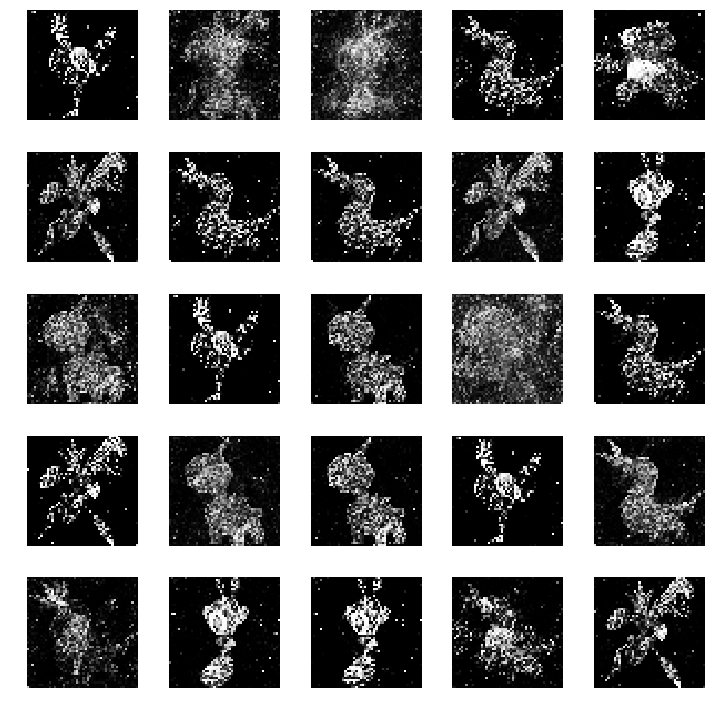

In [307]:
noise = np.random.normal(0, 1, size=(25, noise_dim))
show_images(noise)